In [2]:
using Pkg;
# Pkg.add("ReactionNetworkImporters");
# Pkg.add("Dictionaries");
# Pkg.add("LaTeXStrings");
# Pkg.add("Statistics");
# Pkg.add("ColorSchemes");
# Pkg.add("IterTools"); 
# Pkg.add("NNlib"); 
# Pkg.add("DifferentialEquations");
# # Pkg.add("Plots");
# Pkg.add("Formatting");
# Pkg.add("LinearAlgebra");
# Pkg.add("Noise");
# Pkg.add("Catalyst");

using DifferentialEquations;
using Random;
# using Plots;
using Formatting;
using LinearAlgebra;
using Noise;
using ReactionNetworkImporters;
using Dictionaries;
using LaTeXStrings;
using Statistics;
using ColorSchemes;
using Catalyst;
using IterTools;
using NNlib;

nothing

In [3]:
include("datasets.jl")
train = create_annular_rings_dataset(150)
val = create_annular_rings_dataset(50)

51-element Vector{Any}:
 [-0.8201624155044556 0.012012249790132046 1.0]
 [0.1993832290172577 0.8627095818519592 1.0]
 [-0.1299254149198532 0.803433895111084 1.0]
 [0.28356820344924927 -0.0713706985116005 0.0]
 [0.8040053844451904 0.17772604525089264 1.0]
 [0.1936011016368866 -0.14101684093475342 0.0]
 [-0.20243947207927704 0.9012791514396667 1.0]
 [-0.0892697349190712 -0.029400914907455444 0.0]
 [0.8408216238021851 0.2332552969455719 1.0]
 [0.07160218060016632 -0.19256213307380676 0.0]
 [-0.8761736154556274 0.01285921223461628 1.0]
 [-0.19305647909641266 -0.1350587010383606 0.0]
 [-0.6350734233856201 -0.6059245467185974 1.0]
 ⋮
 [0.1836920529603958 -0.17922227084636688 0.0]
 [-0.8347717523574829 0.0701669305562973 1.0]
 [0.28551241755485535 -0.02214224264025688 0.0]
 [0.06980495899915695 -0.2857690751552582 0.0]
 [-0.27266907691955566 -0.006950006354600191 0.0]
 [0.37695392966270447 -0.7771703004837036 1.0]
 [-0.03324311599135399 -0.22413338720798492 0.0]
 [-0.0846400335431099 -0.12722

In [4]:

include("utils.jl")

nothing

In [5]:
1/sqrt(3)*rand(-2:2, 3, 3)

3×3 Matrix{Float64}:
 0.57735   0.57735  0.57735
 0.0       0.57735  0.57735
 0.0      -1.1547   0.0

In [6]:
DIMS=3
params_orig = create_node_params(DIMS, t0=0.0, t1=3.0)
# params_orig = [3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 1.0]

19-element Vector{Any}:
 3.0f0
 0.368599532292737
 0.3474966737807135
 0.2980509002309464
 0.27577320483927736
 0.27415947014940745
 0.24021677211855835
 0.29983436232245936
 0.28744669323726246
 0.21771366465925812
 0.1
 0.1
 0.1
 1.0
 1.0
 1.0
 0.5
 0.0
 3.0

In [7]:
function f(u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    _, theta, beta, w, h, _, _ = sequester_params(p)
 
    hvec = ones(length(u))*h
    fmat = (theta*x + beta).*u - u.*u + hvec
    return fmat
end

function forward!(du, u, xAndp, t)
    x = xAndp[1:3]
    p = xAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = f(u, xAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


# Calculates the final hidden state of the neural ode
function forward_node(u0, xAndp, tspan)
    prob = ODEProblem(forward!, u0, tspan, xAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end


function backward!(du, u, sAndp, t)
    s = sAndp[1:3]
    p = sAndp[4:end]
    dims, theta, beta, w, h, _, _ = sequester_params(p)
    fmat = -f(u, sAndp, t)
    for i in 1:length(fmat)
        du[i] = fmat[i]
    end
end


function backward_node(s0, sAndp, tspan)
    prob = ODEProblem(backward!, s0, tspan, sAndp)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

backward_node (generic function with 1 method)

ODE | Input: [1.025242066383362, 0.0898539274930954, 0.1] | Target: 0.0
params before | Any[3.0f0, 0.368599532292737, 0.3474966737807135, 0.2980509002309464, 0.27577320483927736, 0.27415947014940745, 0.24021677211855835, 0.29983436232245936, 0.28744669323726246, 0.21771366465925812, 0.1, 0.1, 0.1, 1.0, 1.0, 1.0, 0.5, 0.0, 3.0]


┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/JUp1I/src/performance_warnings.jl:33


Ideal ReLU | [1.5641748434921872, 0.5212442002398844, 0.5550023819984127]
ODE | z at t=T | [1.0261677923344659, 0.9306698916276516, 0.946324645599659]
ODE | Input: [1.025242066383362, 0.0898539274930954, 0.1] 
ODE | z at t=0 | [-0.32069107830386595; -0.351563715678658; -0.3478128746426076;;]
[1.0261677923344659, 0.9306698916276516, 0.946324645599659]

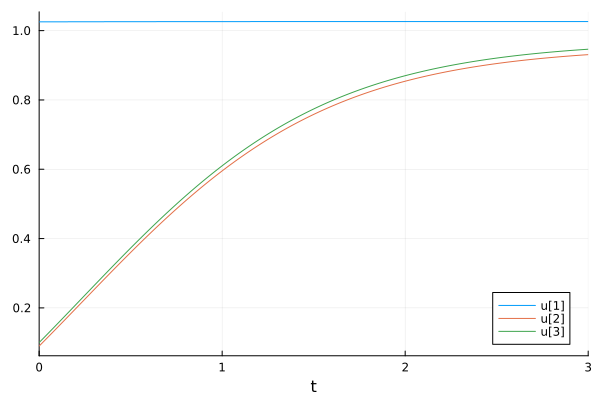

In [8]:
function node_main(params, train, val; DIMS=3, EPOCHS=20, LR=0.001, threshold=nothing)
    for trindex in eachindex(train)
        x, y = get_one(train, trindex)
        # Augment
        x = augment(x, DIMS-length(x))

        for i in eachindex(x)
            x[i] = abs(x[i])
        end
        x[3] = 0.1
        x = [1.02524206638336182, 0.0898539274930954, 0.1]
        println("ODE | Input: $x | Target: $y")
        dims, theta, beta, w, h, t0, t1 = sequester_params(params)
        
        println("params before | ", params)
        xAndp = vcat(x, params)
        tspan = (t0, t1)
        sol = forward_node(x, xAndp, tspan)
        println("Ideal ReLU | ", relu.(x+theta*x + beta))
        println("ODE | z at t=T | ", sol[end])

        z = reshape(sol[end], (DIMS, 1)) 
        s0 = z
        sAndp = vcat(s0, params)
        rtspan = reverse(tspan)
        bsol = backward_node(s0, sAndp, tspan)
        println("ODE | Input: $x ")
        println("ODE | z at t=0 | ", bsol[end])
        println("==================================")
        return sol, bsol
    end
    
end

function neuralode(; DIMS=3)
    # train = create_linearly_separable_dataset(100, linear, threshold=0.0)
    # val = create_linearly_separable_dataset(40, linear, threshold=0.0)
    # val = train   
    sol, bsol = node_main(params_orig, train[1:1], val[1:1], DIMS=DIMS, EPOCHS=30, threshold=0.0, LR=0.001)
    return sol, bsol
end

sol, bsol = neuralode()
print(sol[end])
plot(sol)

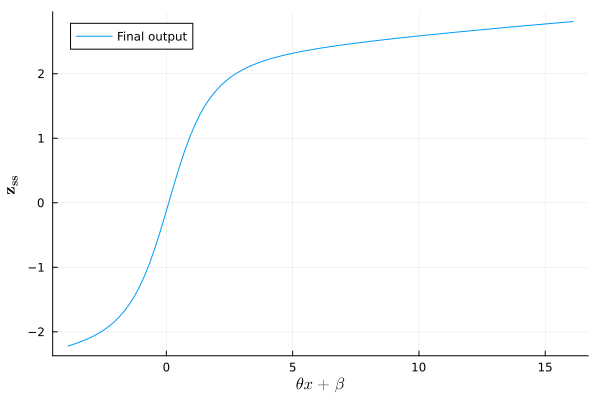

In [39]:
t = 0.8
b = 0.1

xrange = range(-5, 20, 100)
xs = t.*xrange .+ b

function forward!(du, u, p, t)
    # du contains only one z
    x = p[1]
    theta = p[2]
    du[1] = 0.1 + theta*x - u[1]^3
end

function forward_node(u0, p, tspan)
    prob = ODEProblem(forward!, u0, tspan, p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, maxiters=1e5)
    return sol
end

zs = []
for x in xrange
    p = vcat([x, t])
    sol = forward_node([x], p, (0.0, 0.1))
    push!(zs, sol.u[end][1])
end

gg = plot(xs, zs, xlabel=L"$\theta x + \beta$", ylabel=L"$\mathbf{z_{ss}}$", label="Final output")
# png(gg, "activation.png")